# HMS - Harmful Brain Activity Classification

## Overview
The goal of this competition is to detect and classify seizures and other types of harmful brain activity. You will develop a model trained on electroencephalography (EEG) signals recorded from critically ill hospital patients.

> Train the model(s) with EGG data then predict the probability of each EGG patterns that sum to one.

Your work may help rapidly improve electroencephalography pattern classification accuracy, unlocking transformative benefits for neurocritical care, epilepsy, and drug development. Advancement in this area may allow doctors and brain researchers to detect seizures or other brain damage to provide faster and more accurate treatments.

Link: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification

# List of Contents
- Understand Basic Information
- Import Tools
- Exploratory Data Analysis (EDA)
- Data Preprocessing
- Model Training (Baseline)
- Submission

# Understand Dataset Informations

## What is electroencephalography (EEG)?
EEG is a crucial diagnostic tool in neurology, used to detect abnormalities in brain activity. In critically ill patients, EEG monitoring is essential for detecting seizures and other harmful brain patterns that could lead to brain damage. Currently, EEG analysis largely relies on manual interpretation by specialized neurologists, a process that can be time-consuming, costly, and subject to human error.

Learn more at: https://www.acns.org/UserFiles/file/ACNSStandardizedCriticalCareEEGTerminology_rev2021.pdf

## EEG Patterns of Interest
The competition focuses on six EEG patterns:

- Seizure (SZ)
- Generalized Periodic Discharges (GPD)
- Lateralized Periodic Discharges (LPD)
- Lateralized Rhythmic Delta Activity (LRDA)
- Generalized Rhythmic Delta Activity (GRDA)
- "Other" (unspecified patterns)

## Data Annotation and Categories
- **Idealized Patterns**: High agreement among experts.
- **Proto Patterns**: Mixed labeling between a specific pattern and “Other.”
- **Edge Cases**: Approximately equal split among experts between two of the five named patterns.

Example of EEG Patterns with Different Levels of Expert Agreement:

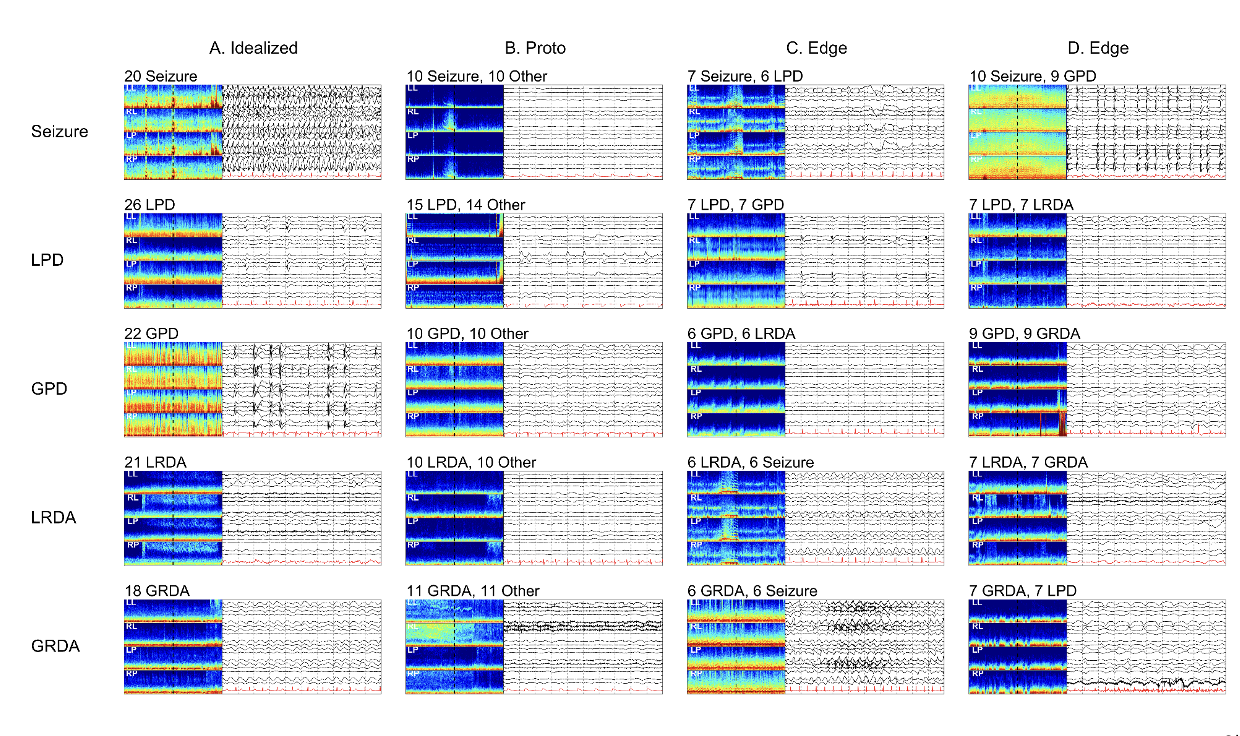

## Evaluation Metric
Kullback Liebler Divergence: Measures the divergence between predicted probabilities and observed targets. Predictions must sum to one for each `eeg_id`.


## Dataset Description
- **EEG Data**: Contains EEG recordings from patients, sampled at 200 samples per second.
- **Spectrograms**: Visual representations of the EEG data.
- **Metadata**: Information about EEG recordings, spectrograms, and patient details.
- **Annotator Votes**: Counts of votes for each brain activity class by experts.

## EGGs (waveforms) vs Spectrograms (images)
- EEGs directly measure the electrical activity of the brain through electrodes placed on the scalp. Offers more detailed and raw temporal data about brain activity
- Spectrograms are visual representations of the spectrum of frequencies of the EEG signal as they vary over time. Offers a time-frequency representation, capturing both the frequency content and how it changes over time.


## Submission Requirements
Participants must predict probabilities for each of the six brain activity patterns for each EEG segment in the test set. The submission format includes `eeg_id` followed by predicted probabilities for each pattern.

***Your total predicted probabilities for each row must sum to one or your submission will fail.***

# Import Tools

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import random

import seaborn as sns

from torch.utils.data import Dataset, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.nn.functional import pad

from sklearn.model_selection import GroupKFold
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score
import itertools

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


# Exploratory Data Analysis (EDA)

## Data Collection

In [3]:
# !kaggle competitions download -c hms-harmful-brain-activity-classification
# !kaggle datasets download -d cdeotte/brain-spectrograms

In [4]:
# !tar -xf hms-harmful-brain-activity-classification.zip
# !tar -xf brain-spectrograms.zip

In [5]:
# root_path1 = "/kaggle/input/hms-harmful-brain-activity-classification/"
# root_path2 = "/kaggle/input/brain-spectrograms/"

root_path1 = ""
root_path2 = ""

train_df = pd.read_csv(root_path1 + 'train.csv')
test_df = pd.read_csv(root_path1 + 'test.csv')
train_df.shape, test_df.shape

((106800, 15), (1, 3))

In [6]:
train_df.sample(5)

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
20699,2867990110,0,0.0,404311364,0,0.0,98535019,2338,GPD,0,0,11,0,1,3
91751,2038578272,15,270.0,1863712617,497,9890.0,2391553354,35225,LPD,0,3,0,0,0,0
106769,2918003806,6,56.0,2146170054,6,56.0,338964520,33380,Seizure,3,0,0,0,0,0
102069,199316279,8,44.0,2040891277,8,44.0,2340713002,37552,Seizure,3,0,0,0,0,0
53530,753662060,2,4.0,1062061146,2,4.0,203409884,53661,LRDA,0,0,0,3,0,0


Original Spectrograms (Won't use it)

In [7]:
pd.read_parquet(root_path1 + "train_spectrograms/1000086677.parquet").head()

,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
0,1,28.680000,53.990002,67.629997,59.880001,50.880001,74.309998,78.480003,63.080002,59.869999,...,0.13,0.14,0.08,0.11,0.04,0.03,0.05,0.05,0.04,0.05
1,3,29.639999,38.959999,44.009998,66.800003,48.509998,42.180000,47.340000,48.599998,40.880001,...,0.15,0.13,0.08,0.08,0.07,0.06,0.07,0.06,0.06,0.06
2,5,8.890000,9.020000,16.360001,23.559999,27.340000,30.040001,27.559999,23.290001,15.120000,...,0.12,0.11,0.08,0.08,0.09,0.10,0.12,0.14,0.13,0.14
3,7,1.770000,1.930000,1.810000,1.600000,1.430000,1.280000,1.190000,1.110000,1.010000,...,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.04,0.04,0.04
4,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Thanks to Chris Deotte for simplifying the dataset, here is the link:
https://www.kaggle.com/datasets/cdeotte/brain-spectrograms, 

He also provided how to use the data using Tensorflow, But since I prefer PyToch lets modify it a bit.

In [8]:
spectrograms = np.load(root_path2+ 'specs.npy',allow_pickle=True).item()
len(spectrograms)

11138

In [9]:
for i in spectrograms.items():
    print(i)
    break

(319287046, array([[16.72, 24.51, 36.19, ...,  0.1 ,  0.34,  0.35],
       [16.65, 19.84, 18.75, ...,  0.13,  0.46,  0.42],
       [ 8.47,  8.57, 11.68, ...,  0.12,  0.4 ,  0.38],
       ...,
       [43.94, 34.39, 36.66, ...,  0.31,  0.63,  0.52],
       [53.59, 73.56, 64.55, ...,  0.23,  0.47,  0.57],
       [54.76, 80.39, 76.  , ...,  0.49,  0.89,  0.81]], dtype=float32))


## Understanding the Data

<Axes: xlabel='expert_consensus', ylabel='Count'>

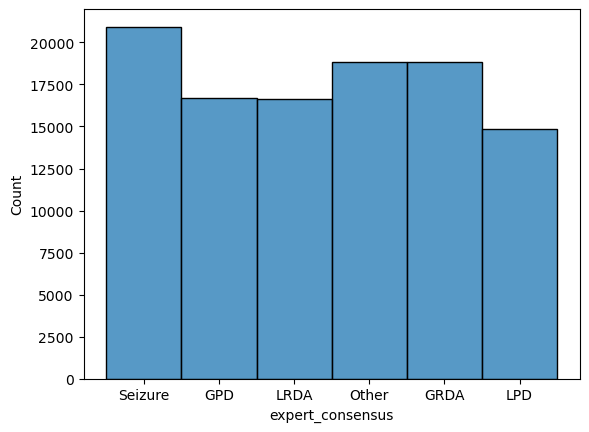

In [10]:
sns.histplot(train_df["expert_consensus"])

The classes are pretty much balanced. Good.

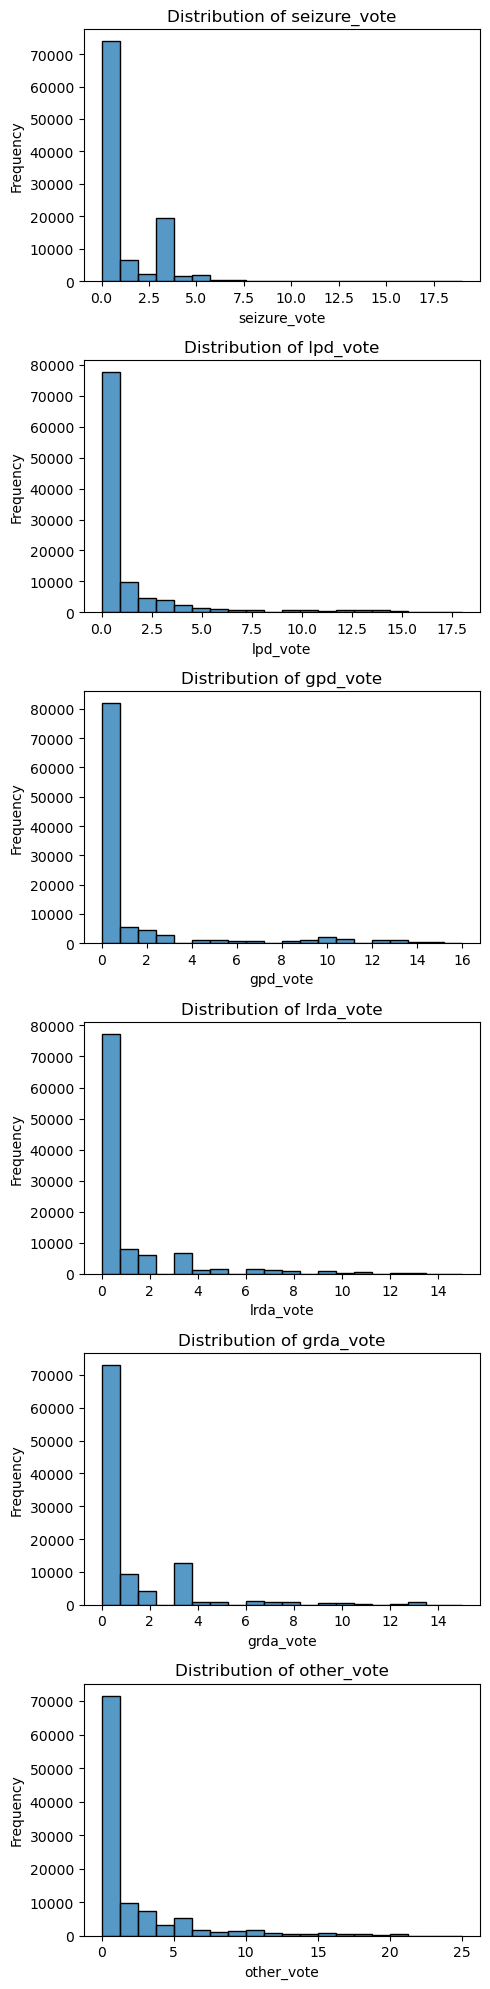

In [11]:
columns_to_plot = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']

fig, axes = plt.subplots(nrows=len(columns_to_plot), ncols=1, figsize=(5, 20))

for i, col in enumerate(columns_to_plot):
    sns.histplot(train_df[col], bins=20, kde=False, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [12]:
def plot_spectrogram(eeg_id, spectrogram):
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram, aspect='auto', origin='lower')
    plt.colorbar()
    plt.title(f'Spectrogram for EEG ID: {eeg_id}')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()


# Data Preprocessing

## Create Non-Overlapping Eeg Id Train Data
Credit: https://www.kaggle.com/code/cdeotte/catboost-starter-lb-0-67

In [13]:
TARGETS = train_df.columns[-6:]
train = train_df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train.columns = ['spec_id','min']

tmp = train_df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train['max'] = tmp

tmp = train_df.groupby('eeg_id')[['patient_id']].agg('first')
train['patient_id'] = tmp

tmp = train_df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values
    
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

tmp = train_df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train_df = train.reset_index()
print('Train non-overlapp eeg_id shape:', train_df.shape )
train_df.head()

Train non-overlapp eeg_id shape: (17089, 12)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


## Feature Engineer

In [14]:
SPEC_COLS = pd.read_parquet(f'{root_path1}train_spectrograms/1000086677.parquet').columns[1:]
FEATURES = [f'{c}_mean_10m' for c in SPEC_COLS]
FEATURES += [f'{c}_min_10m' for c in SPEC_COLS]
FEATURES += [f'{c}_mean_20s' for c in SPEC_COLS]
FEATURES += [f'{c}_min_20s' for c in SPEC_COLS]
print(f'We are creating {len(FEATURES)} features for {len(train)} rows... ',end='')

We are creating 1600 features for 17089 rows... 

In [15]:
def feature_engineer(df):
    data = np.zeros((len(df),len(FEATURES)))
    for k in range(len(df)):

        row = train.iloc[k]
        r = int( (row['min'] + row['max'])//4 ) 
    
        # 10 MINUTE WINDOW FEATURES (MEANS and MINS)
        x = np.nanmean(spectrograms[row.spec_id][r:r+300,:],axis=0)
        data[k,:400] = x
        x = np.nanmin(spectrograms[row.spec_id][r:r+300,:],axis=0)
        data[k,400:800] = x
    
        # 20 SECOND WINDOW FEATURES (MEANS and MINS)
        x = np.nanmean(spectrograms[row.spec_id][r+145:r+155,:],axis=0)
        data[k,800:1200] = x
        x = np.nanmin(spectrograms[row.spec_id][r+145:r+155,:],axis=0)
        data[k,1200:1600] = x

    return pd.DataFrame(data, columns=FEATURES)


In [16]:
features_df = feature_engineer(train_df)
features_df.head()

C:\Users\USER\AppData\Local\Temp\ipykernel_15500\1639125574.py:15: RuntimeWarning: Mean of empty slice
  x = np.nanmean(spectrograms[row.spec_id][r+145:r+155,:],axis=0)
C:\Users\USER\AppData\Local\Temp\ipykernel_15500\1639125574.py:17: RuntimeWarning: All-NaN slice encountered
  x = np.nanmin(spectrograms[row.spec_id][r+145:r+155,:],axis=0)


,LL_0.59_mean_10m,LL_0.78_mean_10m,LL_0.98_mean_10m,LL_1.17_mean_10m,LL_1.37_mean_10m,LL_1.56_mean_10m,LL_1.76_mean_10m,LL_1.95_mean_10m,LL_2.15_mean_10m,LL_2.34_mean_10m,...,RP_18.16_min_20s,RP_18.36_min_20s,RP_18.55_min_20s,RP_18.75_min_20s,RP_18.95_min_20s,RP_19.14_min_20s,RP_19.34_min_20s,RP_19.53_min_20s,RP_19.73_min_20s,RP_19.92_min_20s
0,320.005035,418.965210,468.401886,438.750214,364.099854,289.576935,232.589294,183.663315,150.056168,124.477470,...,0.20,0.19,0.17,0.16,0.25,0.21,0.17,0.19,0.15,0.13
1,58.221100,64.707634,59.324497,39.724167,26.994200,17.692499,12.047100,9.288233,7.682966,6.277733,...,0.02,0.02,0.02,0.02,0.02,0.02,0.03,0.02,0.02,0.02
2,10.100633,12.456667,13.519967,11.783200,9.385166,6.897967,5.093400,3.298833,2.091267,1.614300,...,0.05,0.04,0.07,0.05,0.04,0.06,0.03,0.06,0.05,0.05
3,27.988499,37.592232,48.323536,54.410072,54.579601,55.704361,55.597767,54.303066,49.619965,48.152267,...,0.06,0.05,0.05,0.06,0.06,0.06,0.07,0.05,0.05,0.03
4,55.133900,59.609035,54.085033,38.695969,29.842068,25.815701,21.814369,17.542032,14.638301,12.792633,...,0.15,0.15,0.13,0.13,0.08,0.06,0.06,0.12,0.09,0.04


In [17]:
train_df

,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
...,...,...,...,...,...,...,...,...,...,...,...,...
17084,4293354003,1188113564,0.0,0.0,16610,0.0,0.000000,0.00,0.000000,0.500000,0.500000,GRDA
17085,4293843368,1549502620,0.0,0.0,15065,0.0,0.000000,0.00,0.000000,0.500000,0.500000,GRDA
17086,4294455489,2105480289,0.0,0.0,56,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
17087,4294858825,657299228,0.0,12.0,4312,0.0,0.000000,0.00,0.000000,0.066667,0.933333,Other


In [18]:
features_df.shape, train_df.shape

((17089, 1600), (17089, 12))

In [19]:
train_df = pd.concat([train_df, features_df], axis=1)
train_df.head()

,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,...,RP_18.16_min_20s,RP_18.36_min_20s,RP_18.55_min_20s,RP_18.75_min_20s,RP_18.95_min_20s,RP_19.14_min_20s,RP_19.34_min_20s,RP_19.53_min_20s,RP_19.73_min_20s,RP_19.92_min_20s
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,...,0.20,0.19,0.17,0.16,0.25,0.21,0.17,0.19,0.15,0.13
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,...,0.02,0.02,0.02,0.02,0.02,0.02,0.03,0.02,0.02,0.02
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,...,0.05,0.04,0.07,0.05,0.04,0.06,0.03,0.06,0.05,0.05
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,...,0.06,0.05,0.05,0.06,0.06,0.06,0.07,0.05,0.05,0.03
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,...,0.15,0.15,0.13,0.13,0.08,0.06,0.06,0.12,0.09,0.04


In [20]:
train_df.isna().sum(), train_df.shape

(eeg_id               0
 spec_id              0
 min                  0
 max                  0
 patient_id           0
                     ..
 RP_19.14_min_20s    18
 RP_19.34_min_20s    18
 RP_19.53_min_20s    18
 RP_19.73_min_20s    18
 RP_19.92_min_20s    18
 Length: 1612, dtype: int64,
 (17089, 1612))

In [21]:
train_df = train_df.dropna().reset_index(drop=True)
train_df.shape

(17071, 1612)

# Model Training

## Setup parameters

In [22]:
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
X = train_df[FEATURES].values
y = train_df['target'].map(TARS).values
groups = train_df['patient_id'].values

param_grid = {
    'learning_rate': [0.001, 0.003, 0.01, 0.03, 0.05],
    'batch_size': [128, 256],
    'scheduler_fn': [
        (torch.optim.lr_scheduler.StepLR, {'step_size': 10, 'gamma': 0.1}),
        (torch.optim.lr_scheduler.ReduceLROnPlateau, {'mode': 'min', 'factor': 0.1, 'patience': 10})
    ]
}

def create_model(params):
    scheduler_fn, scheduler_params = params['scheduler_fn']
    model = TabNetClassifier(
        optimizer_fn=params['optimizer'],
        optimizer_params=dict(lr=params['learning_rate']),
        scheduler_fn=scheduler_fn,
        scheduler_params=scheduler_params
    )
    return model


def kullback_leibler_divergence(true_labels, predictions):
    """
    Calculate the Kullback-Leibler Divergence.
    true_labels: Array of true labels.
    predictions: Array of predicted probabilities.
    """
    # One-hot encode the true labels
    n_classes = predictions.shape[1]
    one_hot_true = np.eye(n_classes)[true_labels]

    # Clip predictions to avoid log(0)
    epsilon = 1e-15
    predictions_clipped = np.clip(predictions, epsilon, 1 - epsilon)

    # Calculate KLD
    kld = np.sum(one_hot_true * np.log(one_hot_true / predictions_clipped), axis=1)
    return np.mean(kld)

## Find the best parameters

In [23]:
# results = []

# for params in (dict(zip(param_grid, x)) for x in itertools.product(*param_grid.values())): # GridSearch every params
#     print(f"Training with params: {params}")
    
#     all_oof = []
#     all_true = []
#     gkf = GroupKFold(n_splits=5)

#     for train_index, valid_index in gkf.split(X, y, groups):
#         X_train, y_train = X[train_index], y[train_index]
#         X_valid, y_valid = X[valid_index], y[valid_index]

#         model = create_model(params)

#         model.fit(X_train, y_train,
#                   eval_set=[(X_valid, y_valid)],
#                   eval_name=['valid'],
#                   eval_metric=['accuracy'],
#                   max_epochs=2000,
#                   batch_size=params['batch_size'],
#                   virtual_batch_size=128,
#                   num_workers=0,
#                   drop_last=False,
#                   patience=30)
        
#         oof = model.predict_proba(X_valid)
#         all_oof.append(oof)
#         all_true.append(y_valid)

#     # Concatenate and move to CPU for metric calculation
#     all_oof = np.concatenate(all_oof)
#     all_true = np.concatenate(all_true)

#     # Calculate metrics
#     predicted_classes = np.argmax(all_oof, axis=1)
#     accuracy = accuracy_score(all_true, predicted_classes)
#     kld = kullback_leibler_divergence(all_true, all_oof)

#     # Store results
#     results.append((params, accuracy, kld))

# best_params = max(results, key=lambda x: x[2])
# print(f"Best parameters: {best_params[0]}, Accuracy: {best_params[1]}, KLD: {best_params[2]}")

## Training

In [24]:
# best_params = {
#     "learning_rate": 0.001,
#     "batch_size": 128,
#     "optimizer_fn": torch.optim.Adam,
#     "scheduler_fn": torch.optim.lr_scheduler.StepLR,
#     "scheduler_params": {"step_size": 10, "gamma": 0.1}
# }

# model = TabNetClassifier(
#     optimizer_fn=best_params["optimizer_fn"],
#     optimizer_params=dict(lr=best_params["learning_rate"]),
#     scheduler_fn=best_params["scheduler_fn"],
#     scheduler_params=best_params["scheduler_params"]
# )

# gkf = GroupKFold(n_splits=5)
# all_oof = []
# all_true = []

# for train_index, valid_index in gkf.split(X, y, groups):
#     X_train, y_train = X[train_index], y[train_index]
#     X_valid, y_valid = X[valid_index], y[valid_index]

#     # Fit the model
#     model.fit(
#         X_train, y_train,
#         eval_set=[(X_valid, y_valid)],
#         eval_name=['valid'],
#         eval_metric=['accuracy'],
#         max_epochs=3000,
#         batch_size=best_params['batch_size'],
#         patience=200,
#         drop_last=False
#     )
    
#     oof = model.predict_proba(X_valid)
#     all_oof.append(oof)
#     all_true.append(y_valid)

# all_oof = np.concatenate(all_oof)
# all_true = np.concatenate(all_true)

# predicted_classes = np.argmax(all_oof, axis=1)
# accuracy = accuracy_score(all_true, predicted_classes)

# print(f"Training complete. Accuracy: {accuracy}")

In [25]:
# torch.save(model, 'complete_tabnet_model.pth')

## Load model

In [31]:
model = torch.load("complete_tabnet_model.pth")

## Evaluation

# Submission

In [32]:
test_df = pd.concat([test_df, feature_engineer(test_df)], axis=1)
test_df.head()

,spectrogram_id,eeg_id,patient_id,LL_0.59_mean_10m,LL_0.78_mean_10m,LL_0.98_mean_10m,LL_1.17_mean_10m,LL_1.37_mean_10m,LL_1.56_mean_10m,LL_1.76_mean_10m,...,RP_18.16_min_20s,RP_18.36_min_20s,RP_18.55_min_20s,RP_18.75_min_20s,RP_18.95_min_20s,RP_19.14_min_20s,RP_19.34_min_20s,RP_19.53_min_20s,RP_19.73_min_20s,RP_19.92_min_20s
0,853520,3911565283,6885,320.005035,418.96521,468.401886,438.750214,364.099854,289.576935,232.589294,...,0.2,0.19,0.17,0.16,0.25,0.21,0.17,0.19,0.15,0.13


In [33]:
X_test = test_df[FEATURES].values
preds = model.predict_proba(X_test)
preds

array([[0.1711232 , 0.17149901, 0.11390647, 0.05906856, 0.10327102,
        0.38113174]], dtype=float32)

In [34]:
sub = pd.DataFrame({'eeg_id':test_df.eeg_id.values})
sub[TARGETS] = preds
sub.to_csv('submission.csv',index=False)
print('Submissionn shape',sub.shape)
sub.head()

Submissionn shape (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.171123,0.171499,0.113906,0.059069,0.103271,0.381132


In [29]:
# Data Preprocessing: Normalize numerical features, encode categorical features, handle missing values appropriately.
# Hyperparameter Tuning: Experiment with different architectures, layers, neurons, activation functions, and optimizers.
# Regularization: Prevent overfitting with techniques like dropout, L1/L2 regularization, and early stopping.
# Interpretability: Use techniques like feature importance scores, attention weights, or model-agnostic methods to understand model behavior.
# Compare with Traditional ML: Benchmark deep learning models against traditional machine learning algorithms (e.g., Random Forest, XGBoost) to assess relative performance.